In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cplAE_MET.utils.load_config import load_config
from cplAE_MET.utils.utils import set_paths, save_ckp
from cplAE_MET.utils.dataset import MET_exc_inh
from cplAE_MET.models.augmentations import get_padded_im, get_soma_aligned_im
from cplAE_MET.utils.plots import plot_m
from pandas.api.types import CategoricalDtype

In [2]:
dir_pth = set_paths('config.toml')
dat, D = MET_exc_inh.from_file(dir_pth['MET_data'])
print( D.keys())
dat

dict_keys(['XT', 'XE', 'XM', 'Xsd', 'cluster_label', 'merged_cluster_label_at40', 'merged_cluster_label_at50', 'merged_cluster_label_at60', 'merged_cluster_label_at70', 'merged_cluster_label_at80', 'merged_cluster_label_at90', 'cluster_id', 'cluster_color', 'class', 'class_id', 'group', 'subgroup', 'specimen_id', 'platform', 'gene_ids', 'E_features', 'M_features', 'hist_ax_de_api_bas'])


met data with 6614 cells

In [3]:
def valid_data(x):
    return np.sum(np.isnan(x).reshape(x.shape[0],-1),axis=1) == 0

def order_cat(obs, cat='cluster', by='id'):
    """Order categories in dataframe for easy plotting
    Args:
        obs: ad.obs with columns f'{cat}_label'
        cat (str): 'cluster' or 'subclass'
        by (str): 'id'
    Returns:
        obs
    """
    df = obs.copy()[[f'{cat}_id', f'{cat}_label']]
    df = df.drop_duplicates().sort_values(by=f'{cat}_id')
    df = df.reset_index(drop=True)
    cat_type = CategoricalDtype(categories=df[f'{cat}_label'].to_list(),
                                ordered=True)
    obs[f'{cat}'] = obs[f'{cat}_label'].astype(cat_type)
    return obs, cat_type

In [4]:
# if the cell is from EM platform, then it is 1 otherwise is 0
# Lets see how many EM and how many patchseq + ME + fmost cells we have
from collections import Counter
Counter(dat.platform)

Counter({0: 6614})

In [5]:
isM_EM_1d = np.logical_and(dat.isM_1d, dat.platform)
isM_nonEM_1d = np.logical_and(dat.isM_1d, ~dat.platform)
print(isM_EM_1d.sum(), isM_nonEM_1d.sum())

0 1619


In [6]:
# samples with M data
isM = dat.isM_1d
#valid_data(dat.XM)

# determines palette and hue order for plots based on cluster ordering
df = pd.DataFrame({'cluster_id': dat.cluster_id[isM],
                  'cluster_label': dat.cluster_label[isM],
                  'cluster_color': dat.cluster_color[isM]})
df, cats = order_cat(df, cat='cluster')
palette = df.drop_duplicates()
palette = dict(zip(palette['cluster_label'], palette['cluster_color']))

In [7]:
M = dat.XM[isM]
sd = dat.Xsd[isM]
cluster = dat.cluster_label[isM]
col = dat.cluster_color[isM]

#### Evaluating normalization of density maps
 - density maps are first transformed into mass maps 
 - radial element of density map denotes an area (which is why the transformation is needed)
 - each mass map (axon, dendrite, apical, basal) is normalized to a fixed value (350) for each cell
 - normalized mass maps are converted back to density maps

Below is a summary of cluster-wise normalized density map sums and maximum values.

In [8]:
np.sum(isM)

1619

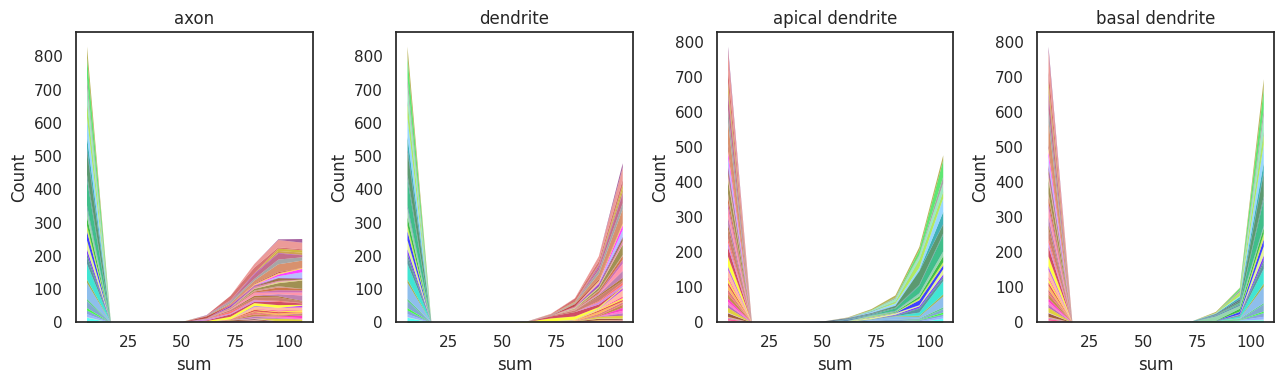

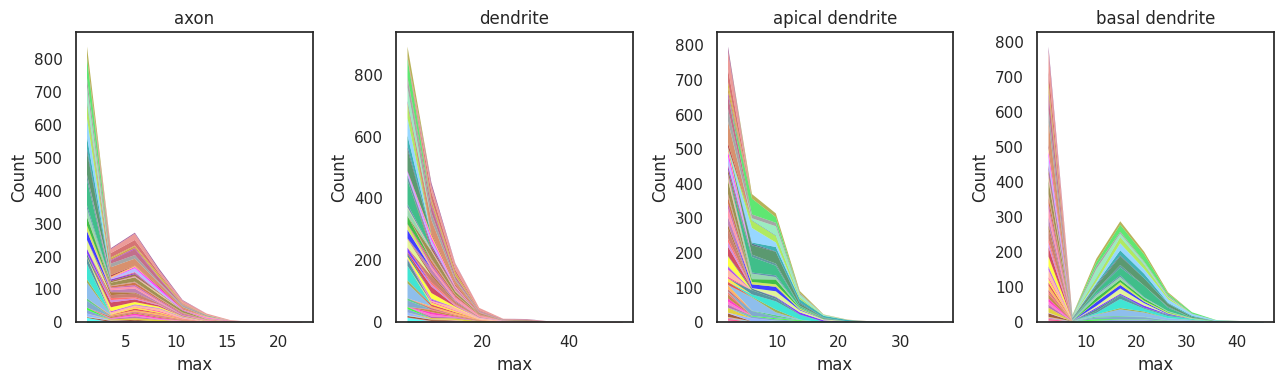

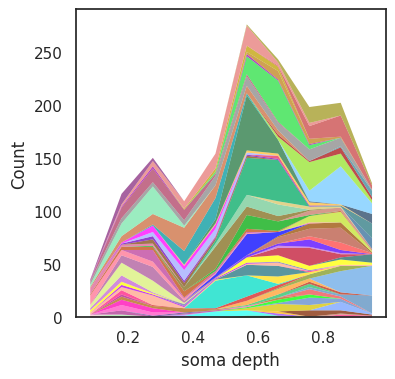

In [9]:
ax_density = {}
de_density = {}
apical_de_density = {}
basal_de_density = {}

# sums of density maps (checking per-channel normalization)
density_sums = np.squeeze(np.apply_over_axes(np.sum, M, [1,2]))
ax_density['sum'] = np.squeeze(density_sums[:,0])
de_density['sum'] = np.squeeze(density_sums[:,1])
apical_de_density['sum'] = np.squeeze(density_sums[:,2])
basal_de_density['sum'] = np.squeeze(density_sums[:,3])

# max values (checking per-channel max)
density_max = np.squeeze(np.apply_over_axes(np.max, M, [1,2]))
ax_density['max'] = np.squeeze(density_max[:,0])
de_density['max'] = np.squeeze(density_max[:,1])
apical_de_density['max'] = np.squeeze(density_max[:,2])
basal_de_density['max'] = np.squeeze(density_max[:,3])

kwargs = dict(x='X',
             bins=10,
             hue='cluster',
             multiple='stack',
             palette=palette,
             linewidth=0,
             legend=False,
             element='poly')

for summary in ['sum','max']:
    f, ax = plt.subplots(1, 4, figsize=(13, 4))
    sns.histplot(data={'X': ax_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[0], **kwargs)
    ax[0].set(title='axon', xlabel=summary)

    sns.histplot(data={'X': de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[1], **kwargs)
    ax[1].set(title='dendrite', xlabel=summary)

    sns.histplot(data={'X': apical_de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[2], **kwargs)
    ax[2].set(title='apical dendrite', xlabel=summary)

    sns.histplot(data={'X': basal_de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[3], **kwargs)
    ax[3].set(title='basal dendrite', xlabel=summary)

    plt.tight_layout()
    plt.show()

f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(data={'X': sd, 'cluster': cluster, 'col': col}, **kwargs)
ax.set(xlabel='soma depth')
plt.show()

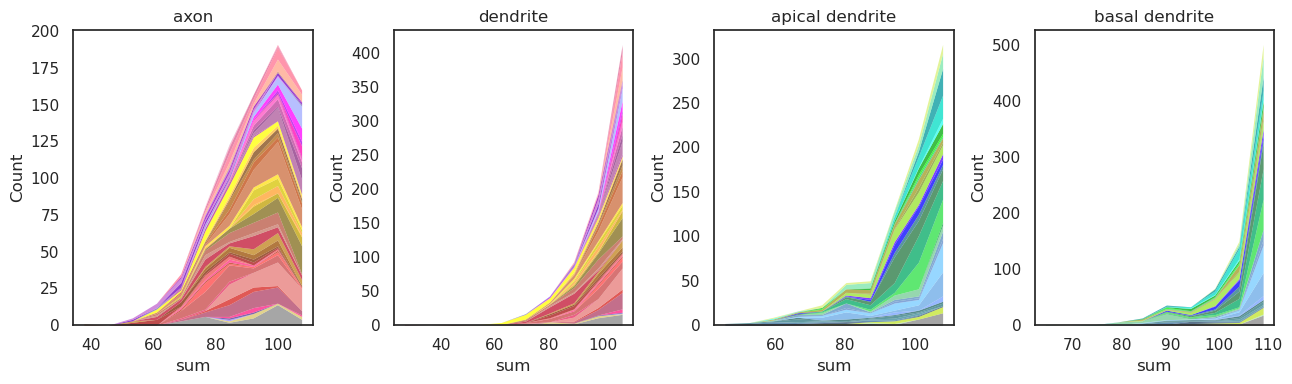

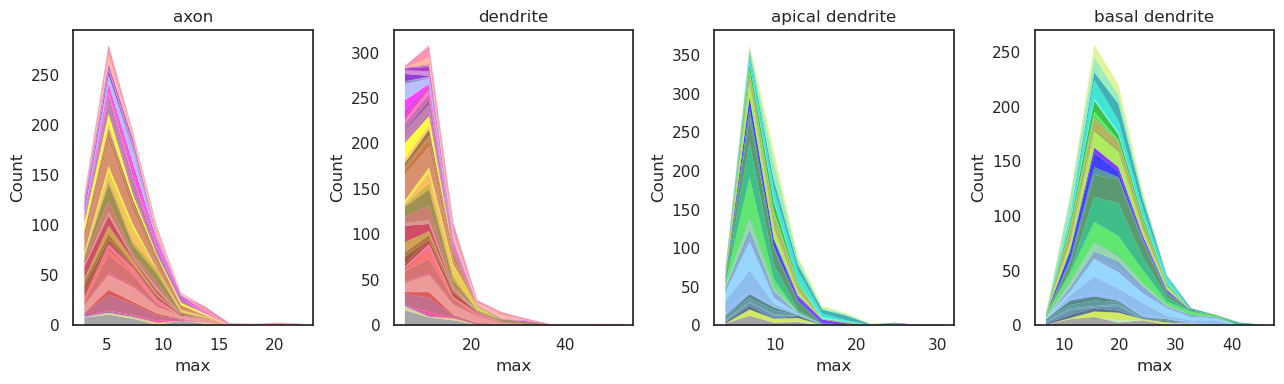

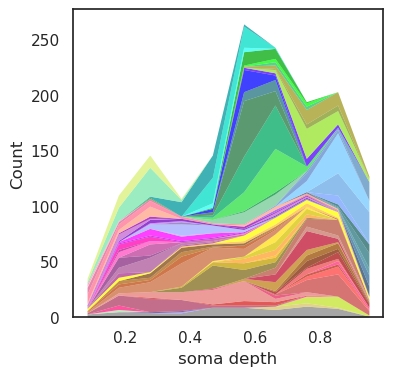

In [6]:
ax_density = {}
de_density = {}
apical_de_density = {}
basal_de_density = {}

# sums of density maps (checking per-channel normalization)
density_sums = np.squeeze(np.apply_over_axes(np.sum, M, [1,2]))
ax_density['sum'] = np.squeeze(density_sums[:,0])
de_density['sum'] = np.squeeze(density_sums[:,1])
apical_de_density['sum'] = np.squeeze(density_sums[:,2])
basal_de_density['sum'] = np.squeeze(density_sums[:,3])

# max values (checking per-channel max)
density_max = np.squeeze(np.apply_over_axes(np.max, M, [1,2]))
ax_density['max'] = np.squeeze(density_max[:,0])
de_density['max'] = np.squeeze(density_max[:,1])
apical_de_density['max'] = np.squeeze(density_max[:,2])
basal_de_density['max'] = np.squeeze(density_max[:,3])

kwargs = dict(x='X',
             bins=10,
             hue='cluster',
             multiple='stack',
             palette=palette,
             linewidth=0,
             legend=False,
             element='poly')

for summary in ['sum','max']:
    f, ax = plt.subplots(1, 4, figsize=(13, 4))
    sns.histplot(data={'X': ax_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[0], **kwargs)
    ax[0].set(title='axon', xlabel=summary)

    sns.histplot(data={'X': de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[1], **kwargs)
    ax[1].set(title='dendrite', xlabel=summary)

    sns.histplot(data={'X': apical_de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[2], **kwargs)
    ax[2].set(title='apical dendrite', xlabel=summary)

    sns.histplot(data={'X': basal_de_density[summary], 'cluster': cluster, 'col': col},
                ax=ax[3], **kwargs)
    ax[3].set(title='basal dendrite', xlabel=summary)

    plt.tight_layout()
    plt.show()

f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.histplot(data={'X': sd, 'cluster': cluster, 'col': col}, **kwargs)
ax.set(xlabel='soma depth')
plt.show()

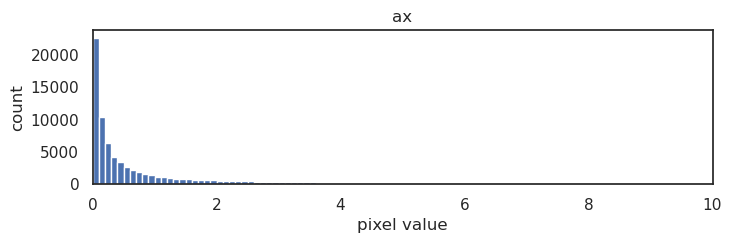

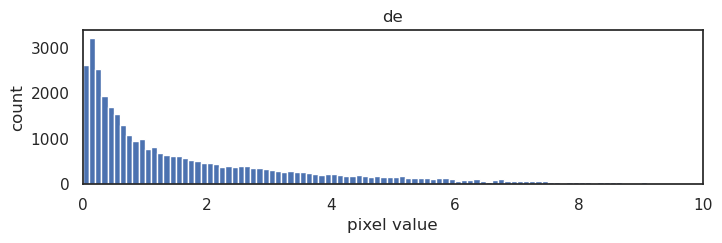

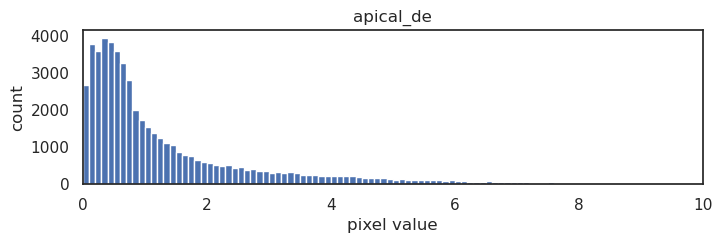

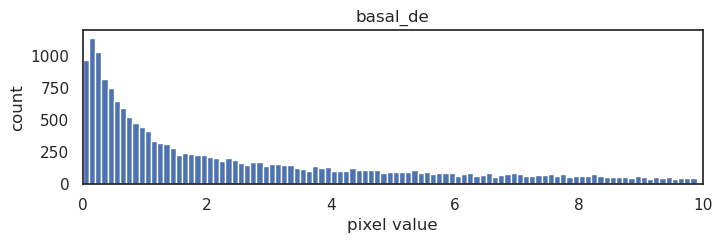

In [7]:
title = ['ax' ,'de' ,'apical_de' ,'basal_de']
for i in range(4):
    xm0 = M[...,i].ravel()
    xm0 = xm0[xm0>0]
    xm0 = xm0[~np.isnan(xm0)]

    f, ax = plt.subplots(1,1,figsize=(8,2))
    _ = plt.hist(xm0, bins=np.arange(-0.1,10,0.1))
    ax.set(xlim = (0,10), xlabel='pixel value', ylabel='count', title=title[i])
    plt.show()

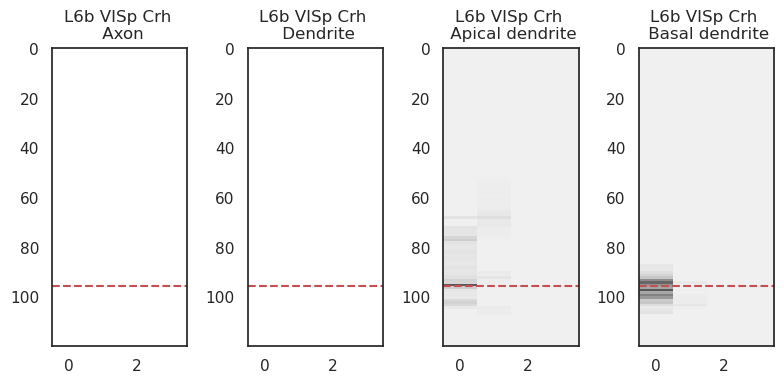

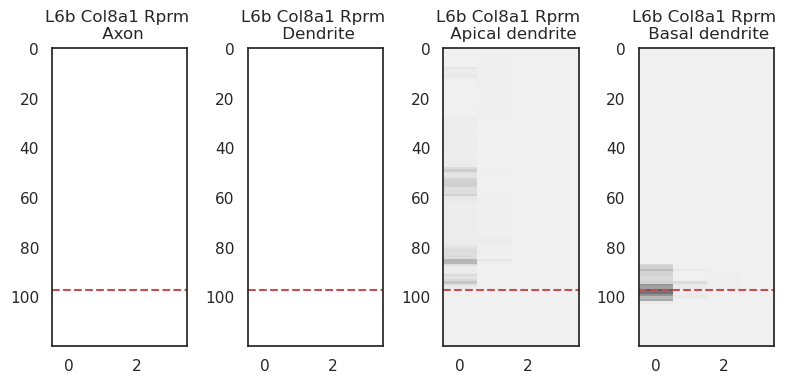

In [8]:
ind = np.flatnonzero(sd > 0.9)
for i in np.random.choice(ind,2):
    plot_m(density_map=np.squeeze(M[i, ...]),
           soma_depth=sd[i]*dat.norm2px,
           cluster_label=cluster[i])

In [9]:
# checks with annotation file - is there any metadata that was left out? (per sample set of marker genes may be a useful for analysis)
import feather

df = feather.read_dataframe(dir_pth['T_anno'])
df = df[['spec_id_label',
         'structure_label',
         'marker_genes',
         'Tree_first_cl_label']]

keep = df['spec_id_label'].astype(int).isin(dat.specimen_id.astype(int))
df = df.loc[keep]

df_ = pd.DataFrame({'specimen_id': dat.specimen_id})
df['spec_id_label'] = df['spec_id_label'].astype(int)
df = df_.merge(right=df,
               how='left',
               left_on='specimen_id',
               right_on='spec_id_label')

df.rename(columns={'spec_id_label': 'specimen_id',
                   'Tree_first_cl_label': 'cluster_anno'},
          inplace=True)


In [10]:
# indicators to set all-zero map to nans
valid_map = ~np.apply_over_axes(np.all, M==0, [1, 2])
valid_map = np.broadcast_to(valid_map, M.shape)
Mnans = M.copy()
Mnans[~valid_map]=np.nan

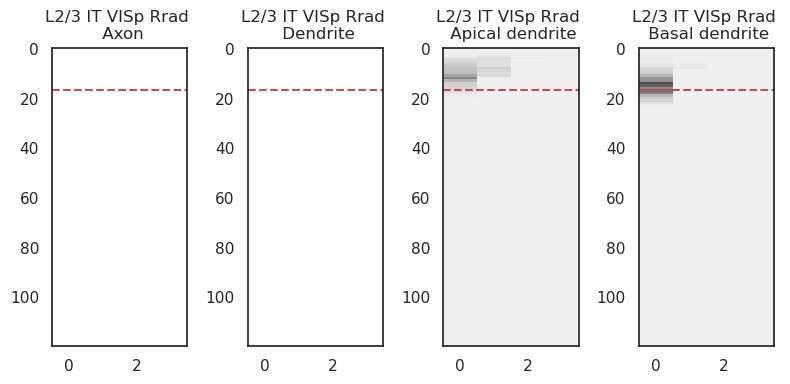

In [11]:
# plot function deals with nans meaningfully.
i = 0
plot_m(density_map=np.squeeze(Mnans[i, ...]),
       soma_depth=sd[i]*dat.norm2px,
       cluster_label=cluster[i])

In [12]:
# baseline regression models to gauge loss values of autoencoder like networks
label = ['Without ignoring all zero maps', 'Ignoring all-zero maps']
for i,M_data in enumerate([M, Mnans]):
    
    # baseline loss values
    mse_zero_reg = np.apply_over_axes(np.nanmean, (M_data - 0)**2, [1, 2])
    mse_zero_reg = np.squeeze(np.apply_over_axes(np.nanmean, mse_zero_reg, [0]))

    map_means = np.apply_over_axes(np.nanmean, M_data, [1, 2])
    error = np.apply_over_axes(np.nanmean, (M_data - map_means)**2, [1, 2])
    mse_mean_reg = np.squeeze(np.apply_over_axes(np.nanmean, error, [0]))

    print(f'\n ---{label[i]}--- \n')
    print(f'constant(0) regression mse: \n'
        + f'axon: {mse_zero_reg[0]:0.3f}    '
        + f'dendrite: {mse_zero_reg[1]:0.3f}    '
        + f'apical: {mse_zero_reg[2]:0.3f}    '
        + f'basal: {mse_zero_reg[3]:0.3f}')

    print(f'constant(mean) regression mse: \n'
        + f'axon: {mse_mean_reg[0]:0.3f}    '
        + f'dendrite: {mse_mean_reg[1]:0.3f}    '
        + f'apical: {mse_mean_reg[2]:0.3f}    '
        + f'basal: {mse_mean_reg[3]:0.3f}')

# ignore runtime warning - it comes from taking the mean of all-nan slices, which does not quantities we are after. 
# note: nanmean of all nan array is nan.


 ---Without ignoring all zero maps--- 

constant(0) regression mse: 
axon: 0.666    dendrite: 1.205    apical: 0.796    basal: 2.306
constant(mean) regression mse: 
axon: 0.628    dendrite: 1.161    apical: 0.753    basal: 2.257

 ---Ignoring all-zero maps--- 

constant(0) regression mse: 
axon: 0.666    dendrite: 1.205    apical: 0.796    basal: 2.306
constant(mean) regression mse: 
axon: 0.628    dendrite: 1.161    apical: 0.753    basal: 2.257


/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/numpy/lib/shape_base.py:495: RuntimeWarning: Mean of empty slice
  res = func(*args)
